In [1]:
# by nitta
import os
is_colab = 'google.colab' in str(get_ipython())   # for Google Colab

if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    SAVE_PREFIX='/content/drive/MyDrive/DeepLearning/openai_gym_rt'
else:
    SAVE_PREFIX='.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 強化学習 (Reinforcement Training)と深層強化学習 (Deep Reinforcement Training)

機械学習には次の3分野がある。
<ul>
<li>教師あり学習</li>
<li>教師なし学習</li>
<li>強化学習</li>
</ul>

ここでは、「強化学習」を扱う。
強化学習とは「対象を支配している法則を知らない状態で試行錯誤を繰り返しながら、望ましい制御方法を学習する」手法である。
何度も試行錯誤しながら、成功した場合は正の報酬を与え、失敗した場合は負の報酬を与えることで、システムは自身の報酬が最大化するように制御ルールを更新していく。
その結果、各局面でシステムが望ましい行動を取るようになる。

強化学習においては、主として、次の2種類の問題を扱う。
<ul>
<li>時間変化をともなうシステムの制御規則の構築 ... ロボットなどの制御ルールを構築する</li>
<li>対戦型ゲームの戦略構築 ... 囲碁・将棋などの対戦ゲームの戦略構築</li>
</ul>

強化学習では、システムに「状態 $s(t)$」を与えると、次に行うべき「行動 $a(t)$」を出力する。
ただし、全ての「状態」における全ての「行動」の組み合わせを列挙するには $\mbox{「状態のパターン数」}\times \mbox{「行動の種類数」}$ の大きさの表 (「表形式表現 (tabular representation)」) が必要となる。この表が大きくなり過ぎると、その問題を扱えなくなってしまう。


そのため
何らかの方法で「状態を縮約(=圧縮) して表現する」必要があるが、状態の圧縮のために「深層ニューラルネットワーク」を利用したのが「深層強化学習」である。


# 1. What is Reinforcement Training?
# 1. 強化学習とは何か

The Components of <b>Reinforcement Training</b> are <b>Agent</b> and <b>Environment</b>.

<ul>

<li><b>Agent</b> selects an <b>Action</b> in the <b>Environment</b> and time advances one step.</li>
<li><b>Agent</b> gets <b>Observation</b> and <b>Reward</b> from <b>Environment</b>.
</ul>


<b>強化学習</b> の構成要素は <b>エージェント</b> と <b>環境</b> である。

<ul>
<li><b>エージェント</b> は <b>環境</b> の中で <b>行動</b> を選択し、時刻が 1 ステップ進む。</li>
<li><b>エージェントは、<b>環境</b> から <b>観測</b> と <b>報酬</b> を得る。</li>
</ul>

# 2. Reinforcement Training: Custom Environment with OpenAI Gym-Style
# 2. 強化学習: OpenAI Gym 形式の環境を自作する

In [2]:
if is_colab:
    !apt update -qq
    !apt install -qq xvfb
    !pip -q install pyvirtualdisplay

39 packages can be upgraded. Run 'apt list --upgradable' to see them.
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [3]:
import gym

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**32

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Show multiple images as animation
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython import display
import os

import gym
def display_frames_as_anim(frames, filepath=None):
    """
    Displays a list of frames as a gif, with controls
    """
    H, W, _ = frames[0].shape
    fig, ax = plt.subplots(1, 1, figsize=(W/100.0, H/100.0))
    ax.axis('off')
    patch = plt.imshow(frames[0])

    def animate(i):
        display.clear_output(wait=True)
        patch.set_data(frames[i])
        return patch

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50, repeat=False)

    if not filepath is None:
        dpath, fname = os.path.split(filepath)
        if dpath != '' and not os.path.exists(dpath):
            os.makedirs(dpath)
        anim.save(filepath)

    if is_colab:
        display.display(display.HTML(anim.to_jshtml()))
        #plt.close()
    else:
        plt.show()

# 3. 迷路問題を強化学習で解く

本稿では「エージェントが迷路を最短路でゴールに向かうように強化学習する」問題を扱い、強化学習の3つのアルゴリズムを説明する。
<ul>
<li>方策勾配法</li>
<li>Sarsa</li>
<li>Q学習</li>
</ul>

## 3.1 gym.Env クラスを拡張して 迷路クラスを定義する
<p>
縦 $H$ 個、横 $W$ 個のマスが2次元上に並んだ迷路を考える。
迷路は、 $H \times W$ の行列で与えられ、行列の各要素(整数)の数値は次の意味を持つ。
<ul>
  <li>EMPTY :$0$ ... 通路 (移動可能)</li>
  <li>BLOCK :$1$ ... 柱 (移動不可能)</li>
  <li>START :$2$ ... スタート地点</li>
  <li>END :$3$ ... ゴール地点</li>
</ul>
</p>

迷路の各マスを1次元のインデックス $0, 1, \cdots, (H\times W -1)$ で表すと、
行 $row$ 、列 $col$ にあるマスのインデックスは
$index = row \times W + col$ と計算できる。
このとき、左上のマスのインデックスは $0$, 右上のマスのインデックスは $(W-1)$, 右下のマスのインデックスは ($W\times H-1)$ となる。

「エージェント」が、「時刻 $t$ にどのマスにいるか」が「状態 $s(t)$ 」となる。
初期状態ではエージェントは「スタート地点」にいるので、
エージェントが各マスで取れる「行動 $a(s(t))$」は以下の4種類である。

<ul>
  <li>上のマスに移動する</li>
  <li>右のマスに移動する</li>
  <li>下のマスに移動する</li>
  <li>左のマスに移動する</li>
</ul>

マスによっては行けない方向があり、選択できる行動が制限される。
あるマス(状態 $s$ )で、エージェントがどの行動 $a$ を取るかは「方策 (polycy)」 $\pi_{\theta}(s, a)$  が表す確率にしたがう。

$\pi_{\theta}(s, a) = $
「エージェントが状態 $s$ において行動 $a$ を選択する確率(ただし $\theta$ はパラメータ)」


$\pi_{\theta}(s, a)$
を representation table で表すと $HW \times 4$ の2次元配列となり、各要素 $p[index][k]$ はエージェントが「状態($index$ )」にいるときに「行動 $k$」を選択する確率を表す。

パラメータ $\theta$ は、方策 $\pi$ の実装方法によってそれぞれの意味となる。
<ul>
<li> $\pi$ が関数の場合は、$\theta$ は関数内のパラメータ</li>
<li> $\pi$ がニューラルネットワークの場合は、$\theta$ は重みパラメータ</li>
<li> $\pi$ が tabular representation の場合は、$\theta$ は確率変数 (= に変換可能な値)</li>
</ul>


In [6]:
# 迷路を表現するクラス
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

class Maze(gym.Env):
    metadata = { 'render.modes' : ['rgb_array']}  # openai


    def __init__(self, map):
        self.EMPTY, self.BLOCK, self.START, self.GOAL = 0, 1, 2, 3
        self.dirs = [(-1,0), (0, 1), (1, 0), (0, -1)]  # (dy, dx): up, right, down, left

        self.map = map
        self.lines, self.cols = map.shape
        self.theta0 = self.get_theta0()
        self.state = self.getIndexOf(self.START)

        self.unit = 1.5
        self.figsize = self.cols * self.unit, self.lines * self.unit
        self.fig, self.ax = plt.subplots(1, 1, figsize=self.figsize)

        self.action_space = gym.spaces.Discrete(4)  # OpenAI
        self.observation_space = gym.spaces.Discrete(self.lines * self.cols)  # OpenAI
        self.reward_range = (0, 1)  # OpenAI


    def reset(self):
        self.state = self.getIndexOf(self.START) # move agent to start point
        return self.state


    def step(self, action):
        self.state = self.get_next_s(action, self.state)
        line, col = self.index2linecol(self.state)
        if self.map[line][col] == self.GOAL:
            done = True
            reward = 1
        else:
            done = False
            reward = 0
        info = {}
        return self.state, reward, done, info


    def render(self, mode='rgb_array'):
        return self.render_with_theta()


    def render_with_theta(self):
        self.plot_maze(pi=self.theta0)
        self.plot_agent(self.state)
        rgb_array = self.fig2array()
        return rgb_array


    def linecol2index(self, line, col):
        return line * self.cols + col


    def index2linecol(self, idx):
        return idx // self.cols, idx % self.cols


    def getIndexOf(self, val, fromIndex=0):
        for idx in range(fromIndex, self.lines * self.cols):
            line, col = self.index2linecol(idx)
            if self.map[line][col] == val: return idx
        return -1


    def get_theta0(self):
        theta = []
        for idx in range(self.lines * self.cols):
            line, col = self.index2linecol(idx)
            for dl, dc in self.dirs:
                nl = line + dl
                nc = col + dc
                if self.map[line][col] == self.BLOCK or nl < 0 or nl >= self.lines or nc < 0 or nc >= self.cols or self.map[nl][nc] == self.BLOCK:
                    theta.append(np.nan)
                else:
                    theta.append(1)
        return np.array(theta).reshape(-1, 4)


    def get_next_s(self, action, state):
        flag = self.theta0[state, action]
        if np.isnan(flag): return state
        line, col = self.index2linecol(state)
        dl, dc = self.dirs[action]
        nl = line + dl
        nc = col + dc
        n_state = self.linecol2index(nl, nc)
        return n_state


    def plot_maze(self, pi=None):
        u = self.unit
        W, H = self.figsize
        self.ax.cla()

        self.ax.axis('off')
        self.ax.add_patch(patches.Rectangle((0,0), W, H, edgecolor='black', fill=False))

        for idx in range(self.lines * self.cols):
            line, col = self.index2linecol(idx)
            x = col * u
            y = H - (line + 1) * u
            if self.map[line][col] == self.EMPTY:
                ec, fc = 'black', 'white'
            elif self.map[line][col] == self.BLOCK:
                ec, fc = 'black', 'lightgray'
            elif self.map[line][col] == self.START:
                ec, fc = 'blue', 'cyan'
            else:
                ec, fc = 'red', 'pink'

            if fc == 'none':
                self.ax.add_patch(patches.Rectangle((x, y), u, u, edgecolor=ec, fill=False))
            else:
                self.ax.add_patch(patches.Rectangle((x, y), u, u, facecolor=fc, edgecolor=ec))

            self.ax.text(x+u/2, y+u/2, f'S{idx}', size=12, ha='center', va='center')

            if not pi is None:
                p = pi.reshape(self.lines, self.cols, -1)
                self.ax.text(x+u/2, y+u-.05, f'{p[line][col][0]:.3f}', size=8, ha='center', va='top')
                self.ax.text(x+u-.05, y+u/2, f'{p[line][col][1]:.3f}', size=8, ha='right', va='center')
                self.ax.text(x+u/2, y+.05, f'{p[line][col][2]:.3f}', size=8, ha='center', va='bottom')
                self.ax.text(x+.05, y+u/2, f'{p[line][col][3]:.3f}', size=8, ha='left', va='center')

        self.ax.autoscale()

        #plt.show()


    def plot_agent(self, agent=-1):
        u = self.unit
        W, H =self.figsize
        if agent < 0: return None
        line, col = self.index2linecol(agent)
        x = col * u + u/2
        y = H - (line + 1) * u + u/2
        line2d, = self.ax.plot([x], [y], marker='o', color='g', markersize=int(u*100/4))
        return line2d


    def fig2array(self):
        self.fig.canvas.draw()
        w, h = self.fig.canvas.get_width_height()
        buf = np.frombuffer(self.fig.canvas.tostring_rgb(), dtype=np.uint8)
        buf.shape = (h, w, 3)
        return buf

## 3.2. 迷路のインスタンス (環境) を生成する

In [7]:
# Generate a maze. 1D array of 1x20  is reshaped to 2D array of 4x5.
# 迷路を生成する。要素数20の1次元配列を4x5の2次元配列に reshape している。

map = np.array([
    2, 0, 0, 0, 0,
    0, 0, 0, 1, 0,
    0, 1, 0, 1, 1,
    0, 1, 0, 0, 3
]).reshape(-1, 5)

In [8]:
import numpy as np

env = Maze(map)

<IPython.core.display.Javascript object>

## 3.3. 方策 $\pi$ のパラメータ $\theta$ の初期値 $\theta_0$

各マスごとに4方向 (上, 右, 下, 左) へ移動できる場合は 1, 移動できない場合は NaN を入れた配列を作成する。

$\theta_0$.shape = ( 行$\times$列 , 4)

In [9]:
# theta0 : 各マス(state)における action の選択可能性
#   action: up, right, down, left
print(env.theta0)

[[nan  1.  1. nan]
 [nan  1.  1.  1.]
 [nan  1.  1.  1.]
 [nan  1. nan  1.]
 [nan nan  1.  1.]
 [ 1.  1.  1. nan]
 [ 1.  1. nan  1.]
 [ 1. nan  1.  1.]
 [nan nan nan nan]
 [ 1. nan nan nan]
 [ 1. nan  1. nan]
 [nan nan nan nan]
 [ 1. nan  1. nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [ 1. nan nan nan]
 [nan nan nan nan]
 [ 1.  1. nan nan]
 [nan  1. nan  1.]
 [nan nan nan  1.]]


In [10]:
# [codingの注意] numpy.nan の判定には numpy.isnan() を使うこと。
print(np.nan == np.nan)
print(np.isnan(np.nan))

False
True


## 3.4. 環境の初期状態を画像表示する
<p>
迷路の画像中で、
エージェントは<font color="green">緑の丸</font>で、
通れないマスは<font color="grey">灰色のマス</font>で、
ゴールは<font color="red">赤色のマス</font> で表現される。
</p>

<p>
各マスの上下左右に表示される文字列は、実数値 $1.000$ がその方向に移動できることを、NaN はその方向に進めないことを表している。
</p>

<p>
迷路の各 state (状態、マス)で agent が取りうる action (行動)を表示する。
</p>

- agent の位置(マス番号)が state (状態) である。
- 各 state は、agent がその state で取りうる行動の可能性 (1: 可能, nan: 不可能)が示される。= theta_0
- 初期状態で、agent は緑丸の位置にいる。

In [11]:
# 迷路の状態を初期化して、画像で表示する
env.reset()
img = env.render()

In [12]:
print(img.shape)

(600, 750, 3)


<IPython.core.display.Javascript object>

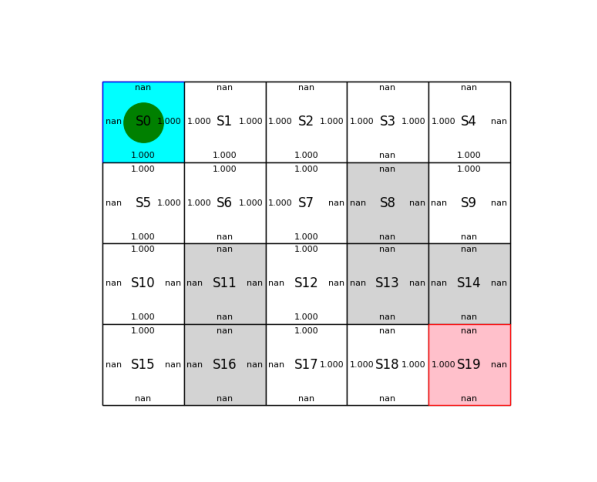

In [13]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=env.figsize)
ax.imshow(img)
ax.axis('off')
plt.show()

## 3.5. ランダムに行動を選択する

In [14]:
# ランダムに行動を選択して 100 step or ゴールまで行動する

frames = []
obs = env.reset()
frames.append(env.render())
states = [ obs ]
for _ in range(50):
    action = env.action_space.sample()     # a random number between 0 and 3
    obs, reward, done, info = env.step(action)
    frames.append(env.render())
    states.append(obs)
    if done:
        break

In [15]:
# 状態遷移
print(len(states))
print(states)

51
[0, 0, 0, 0, 5, 10, 10, 10, 15, 10, 5, 0, 0, 5, 0, 0, 5, 5, 6, 1, 1, 0, 0, 1, 0, 1, 2, 7, 6, 1, 2, 3, 2, 1, 0, 5, 10, 15, 15, 15, 15, 15, 10, 15, 10, 5, 6, 5, 5, 5, 6]


In [16]:
# アニメーション表示する
%matplotlib notebook
import matplotlib.pyplot as plt

#display_frames_as_anim(frames)    # display now
display_frames_as_anim(frames, 'maze_video1.mp4')   # save to file

if is_colab: # copy to google drive
    ! mkdir -p {SAVE_PREFIX}
    ! cp maze_video1.mp4 {SAVE_PREFIX}

Output hidden; open in https://colab.research.google.com to view.

#### 実行の様子を動画で表示する (HTML)

<video controls width="800">
  <source src="./maze_video1.mp4" />
</video>

# 4. 方策 $\pi_{\theta}$


各 state において、agent が取りうる行動の 確率分布 $\pi_{\theta}$ を方策として利用する。

各状態で選択可能な action の確率分布の和が1となるように、すなわち、NaN ではない数値の和が1となるように、それぞれの action の確率分布を計算する。

迷路問題では、各マスにおける「4方向それぞれの隣のマスに移動する確率」である。

## 4.1. 方策 $\pi_{\theta}$ の初期値 $\pi_0$


$\pi_{\theta}$ の初期値 $\pi_0$ を $\theta_0$ を用いて計算する。

In [17]:
# 迷路と方策 pi を表現するクラス

class MazePi(Maze):

    def __init__(self, map):
        super().__init__(map)

        self.pi = self.get_pi(self.theta0)


    def render(self, mode='rgb_array'):
        return self.render_with_pi()


    def render_with_pi(self):
        self.plot_maze(pi=self.pi)
        self.plot_agent(self.state)
        rgb_array = self.fig2array()
        return rgb_array


    def get_pi(self, theta):
        n_state, n_action = theta.shape
        total = np.nansum(theta, axis=1).reshape(n_state, 1)
        pi = theta / total
        return np.nan_to_num(pi)   # convert nan to 0.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
env = MazePi(map)

<IPython.core.display.Javascript object>

In [19]:
# 方策 pi0
print(env.pi)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.         0.5        0.        ]
 [0.         0.         0.         0.        ]
 [0.5        0.         0.5        0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.         1.        ]]


## 4.2. 方策 $\pi_{0}$ の確率分布にしたがって行動を選択する(学習なし)

In [20]:
# 方策 pi0 の確率分布にしたがって行動を選択して 100 step or ゴールまで行動する(学習なし)
frames = []
obs = env.reset()

frames.append(env.render())
states = [ obs ]
for _ in range(50):
    action = np.random.choice(range(4), p=env.pi[env.state])   # probability
    obs, reward, done, info = env.step(action)
    frames.append(env.render())
    states.append(obs)
    if done:
        break

In [21]:
# 状態遷移を表示する
print(len(states))
print(states)

51
[0, 5, 0, 5, 10, 5, 0, 1, 6, 1, 0, 1, 6, 1, 2, 7, 2, 1, 2, 3, 4, 3, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 3, 2, 3, 2, 3, 4, 9, 4, 3, 2, 3, 2, 1, 2, 3, 2, 1, 0]


<p>
迷路の画像中で、
エージェントは<font color="green">緑の丸</font>で、
通れないマスは<font color="grey">灰色のマス</font>で、
ゴールは<font color="red">赤色のマス</font> で表現される。
</p>

<p>
各マスの上下左右に表示される実数値 $[0, 1]$ は、エージェントが移動先でそれぞれの方向を選択する確率 $\pi_{\theta}(s, a)$ である。
</p>

In [22]:
# アニメーション表示する
%matplotlib notebook
import matplotlib.pyplot as plt

#display_frames_as_anim(frames)   # display now
display_frames_as_anim(frames, 'maze_video2.mp4')   # save to file

if is_colab: # copy to google drive
    ! mkdir -p {SAVE_PREFIX}
    ! cp maze_video2.mp4 {SAVE_PREFIX}     # copy to the Google Drive

Output hidden; open in https://colab.research.google.com to view.

#### 実行の様子を動画で表示する (HTML)

<video controls width="800">
  <source src="./maze_video2.mp4" />
</video>

# 5. 学習について

## 方策反復法と価値反復法

<ul>
<li>
方策反復法 (Policy Iteration) ... 方策にしたがって行動してゴールにたどり着いたときに、早くゴールできたケースの行動を多く取り入れるように方策を更新する。
</li>
<li>
価値反復法 (Value Iteration) ... ゴールから逆算して、ゴールの1つ手前、2つ手前の状態へとエージェントを順番に誘導するように、状態の価値を更新する。
ゴール以外の状態にも価値(優先度)を与えることになる。
</li>
</ul>



# 6. 方策反復法

方策のパラメータ $\theta$ から、方策 $\pi_{\theta}(s,a)$ を求める方法がある。

一番簡単には、
「 $\theta$ をそのまま割合に変換して方策を求める」方法がある。
また、softmax関数を使って
 $\displaystyle p(\theta_i) = \frac{e^{\beta \theta_i}}{\sum_{j=1}^{N_a} e^{\beta\theta_j}}$
 を計算して使う方法もある。

## 6.1 方策勾配法 (Policy Gradient Method)

方策反復法のアルゴリズムのひとつである方策勾配法 (Policy Gradient Method) を実装する。

成功した一連の行動について、その中に現れた (状態, 行動) の重み $\theta$ を更新する。 $\theta$ から softmax 関数を用いて、方策 (=ある状態における行動の確率分布) $\pi_{\theta}$ を計算する。

$\theta_{s_i,a_j} = \theta_{s_a,a_j} + \eta \cdot \varDelta \theta_{s,a_j}$

$\displaystyle \varDelta \theta_{s, a_j} = \{N(s_i, a_i) - P(s_i, a_j) N(si,a)\} / T$

$\theta_{s_i,a_j}$ :状態(位置) $s_i$ で行動 $a_j$ を歳用する確率を決めるパラメータ<br />
$\tau$ : 学習率<br />
$N(s_i,a_j)$ : 状態 $s_i$ で行動 $a_j$ を採用した回数<br />
$P(s_i, a_j)$ : 現在の方策で状態 $s_i$ で行動 $a_j$ をとる確率<br />
$N(s_i,a)$ : 状態 $s_i$ でなんらかの行動を行った回数<br />
$T$ : ゴールまでにかかった総ステップ数<br />


In [23]:
# numpy の動作確認
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape((3,4))
print(a)
b = np.array([2, 3, 4]).reshape((3,1))
print(b)
c = np.multiply(a, b)
print(c)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
[[2]
 [3]
 [4]]
[[ 2  4  6  8]
 [15 18 21 24]
 [36 40 44 48]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
class MazePolicyGradient(MazePi):

    def __init__(self, map):
        super().__init__(map)
        self.pi = self.softmax_convert_into_pi_from_theta(self.theta0)


    def update_policy(self, s_a_history):
        new_theta = self.update_theta(self.theta0, self.pi, s_a_history)
        new_pi = self.softmax_convert_into_pi_from_theta(new_theta)
        self.theta0 = new_theta
        self.pi = new_pi


    def update_theta(self, theta, pi, s_a_history, eta=0.1):
        new_theta = theta + eta * self.get_delta_theta(theta, pi, s_a_history)
        return new_theta


    def get_delta_theta(self, theta, pi, s_a_history):
        T = len(s_a_history)
        n_state, n_action = theta.shape
        N_si_aj = np.zeros((n_state, n_action))
        for s, a in s_a_history:
            if not np.isnan(a):
                N_si_aj[s, a] += 1
        N_si_a = np.sum(N_si_aj, axis=1).reshape((n_state,1))
        delta_theta = (N_si_aj - np.multiply(pi, N_si_a)) / T
        return delta_theta


    def softmax_convert_into_pi_from_theta(self, theta):
        beta = 1.0
        n_state, n_action = theta.shape
        pi =  np.zeros((n_state, n_action))

        exp_theta = np.exp(beta * theta)
        sum_theta = np.nansum(exp_theta, axis=1).reshape(n_state, 1)
        pi = exp_theta / sum_theta
        pi = np.nan_to_num(pi)  # nan --> 0
        return pi


    def goal_maze(self, max_loop=800, is_anim=False):  # 方策 pi の確率分布にしたがって行動を選択してゴールまで行動する
        obs = self.reset()
        s_a_history = [[self.state, np.nan]]
        frames = []

        if is_anim: frames.append(self.render())
        for i in range(max_loop):
            action = np.random.choice(range(4), p=env.pi[env.state])   # probability
            s_a_history[-1][1] = action
            obs, reward, done, info = env.step(action)
            s_a_history.append([obs, np.nan])
            if is_anim: frames.append(self.render())

            if done:
                break

        return done, s_a_history, frames

## 6.2. ゴールまで行動する

In [25]:
env = MazePolicyGradient(map)

<IPython.core.display.Javascript object>

In [26]:
done = False

while done == False:
    done, s_a_history, frames = env.goal_maze()

In [27]:
# 状態(state)と行動(action)の遷移を表示する
print(len(s_a_history))
print(s_a_history)

68
[[0, 2], [5, 2], [10, 2], [15, 0], [10, 0], [5, 1], [6, 1], [7, 2], [12, 0], [7, 3], [6, 0], [1, 2], [6, 3], [5, 0], [0, 1], [1, 2], [6, 1], [7, 2], [12, 0], [7, 2], [12, 0], [7, 0], [2, 2], [7, 3], [6, 1], [7, 0], [2, 1], [3, 1], [4, 3], [3, 1], [4, 3], [3, 1], [4, 2], [9, 0], [4, 3], [3, 3], [2, 3], [1, 3], [0, 2], [5, 2], [10, 2], [15, 0], [10, 2], [15, 0], [10, 0], [5, 2], [10, 2], [15, 0], [10, 2], [15, 0], [10, 2], [15, 0], [10, 0], [5, 0], [0, 2], [5, 2], [10, 0], [5, 2], [10, 0], [5, 1], [6, 0], [1, 2], [6, 1], [7, 2], [12, 2], [17, 1], [18, 1], [19, nan]]


## 6.3. 成功体験による $\theta$ と $\pi$ の変化

In [28]:
# delta_theta を表示してみる
delta_theta = env.get_delta_theta(env.theta0, env.pi, s_a_history)
print(delta_theta)

[[ 0.         -0.01470588  0.01470588  0.        ]
 [ 0.         -0.01960784  0.0245098  -0.00490196]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.01470588  0.         -0.01470588]
 [ 0.          0.         -0.01470588  0.01470588]
 [-0.01470588 -0.01470588  0.02941176  0.        ]
 [-0.00490196  0.0245098   0.         -0.01960784]
 [-0.00980392  0.          0.01960784 -0.00980392]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.00735294  0.          0.00735294  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.01470588  0.         -0.01470588  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.00735294  0.00735294  0.          0.        ]
 [ 0.          0.00735294  0.         -0.00735294]
 [ 0.          0.          0.  

In [29]:
# 成功した履歴を用いて方針を更新する
env.update_policy(s_a_history)

In [30]:
# 更新された theta0
print(env.theta0)

[[       nan 0.99852941 1.00147059        nan]
 [       nan 0.99803922 1.00245098 0.9995098 ]
 [       nan 1.         1.         1.        ]
 [       nan 1.00147059        nan 0.99852941]
 [       nan        nan 0.99852941 1.00147059]
 [0.99852941 0.99852941 1.00294118        nan]
 [0.9995098  1.00245098        nan 0.99803922]
 [0.99901961        nan 1.00196078 0.99901961]
 [       nan        nan        nan        nan]
 [1.                nan        nan        nan]
 [0.99926471        nan 1.00073529        nan]
 [       nan        nan        nan        nan]
 [1.00147059        nan 0.99852941        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [1.                nan        nan        nan]
 [       nan        nan        nan        nan]
 [0.99926471 1.00073529        nan        nan]
 [       nan 1.00073529        nan 0.99926471]
 [       nan        nan        nan 1.        ]]


In [31]:
# 更新された pi
print(env.pi)

[[0.         0.49926471 0.50073529 0.        ]
 [0.         0.33267982 0.33415077 0.33316941]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.50073529 0.         0.49926471]
 [0.         0.         0.49926471 0.50073529]
 [0.33284278 0.33284278 0.33431445 0.        ]
 [0.33316941 0.33415077 0.         0.33267982]
 [0.33300638 0.         0.33398725 0.33300638]
 [0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.49963235 0.         0.50036765 0.        ]
 [0.         0.         0.         0.        ]
 [0.50073529 0.         0.49926471 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.49963235 0.50036765 0.         0.        ]
 [0.         0.50036765 0.         0.49963235]
 [0.         0.         0.         1.        ]]


## 6.4. 方策勾配法による学習

1 : 64 0.014932982882011059
2 : 54 0.015440191662473068
3 : 348 0.00700847412362271
4 : 188 0.008442656791932013
5 : 38 0.017671478319624123
6 : 152 0.009761623807974407
7 : 10 0.03835646746487076
8 : 92 0.0153345188005104
9 : 206 0.008670403709017172
10 : 84 0.014388364947537424
20 : 540 0.005113304694722598
30 : 38 0.013267348779161026
40 : 56 0.012342612876857062
50 : 32 0.026393525222891734
60 : 222 0.009455891769116764
70 : 154 0.007725234182932972
80 : 66 0.013386567558060836
90 : 50 0.014906645299587129
100 : 112 0.009590595896240062
200 : 8 0.03846877352992323
300 : 26 0.024820966339403727
400 : 12 0.022872771310525897
500 : 62 0.016479657192321473
600 : 52 0.01258882477628695
700 : 18 0.01584876943493249
800 : 18 0.02724271812856316
900 : 30 0.01735960608035106
1000 : 14 0.024296737822913472
2000 : 10 0.016836254447159943
3000 : 8 0.012000826265791284
4000 : 8 0.008181908446773759
5000 : 20 0.013270389280625457
6000 : 8 0.00617918593115525
7000 : 12 0.008328957320222846
8000 :

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

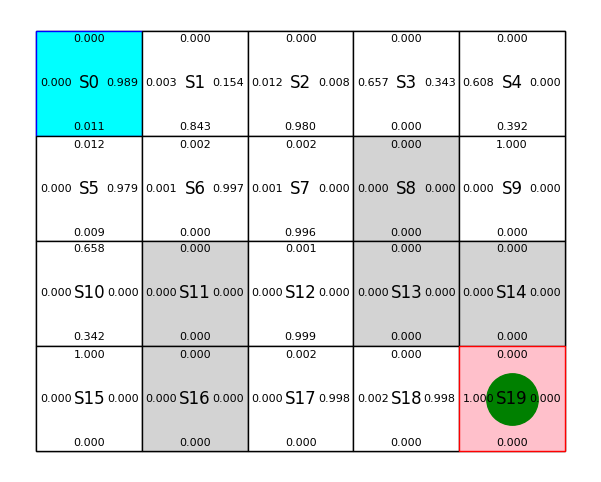

In [32]:
# Policy Gradient Method を用いて、迷路問題を解く
%matplotlib inline

env = MazePolicyGradient(map)

stop_epsilon = 10**-4  # pi の変化がこれより小さくなったら終了

def isLog(i):
    j = i + 1
    return j < 10 or (j < 100 and j % 10 == 0) or (j < 1000 and j % 100 == 0) or (j < 10000 and j % 1000 == 0) or j % 10000 == 0

frames = []
env.reset()
frames.append(env.render())
for i in range(100000):
    env.reset()
    done, s_a_history, _ = env.goal_maze()

    if done:
        old_pi = env.pi
        env.update_policy(s_a_history)

        new_epsilon = np.sum(np.abs(env.pi - old_pi))
        if  new_epsilon < stop_epsilon:
            print(f'done: {i+1} : {len(s_a_history)} {new_epsilon}')
            frames.append(env.render())
            break

        if isLog(i):
            print(f'{i+1} : {len(s_a_history)} {new_epsilon}')
            frames.append(env.render())

In [33]:
# アニメーション表示する
%matplotlib notebook
import matplotlib.pyplot as plt

#display_frames_as_anim(frames)   # display now
display_frames_as_anim(frames, 'maze_video3.mp4')   # save to file

if is_colab: # copy to google drive
    ! mkdir -p {SAVE_PREFIX}
    ! cp maze_video3.mp4 {SAVE_PREFIX}     # copy to the Google Drive

Output hidden; open in https://colab.research.google.com to view.

#### 実行の様子を動画で表示する(HTML)

<video controls width="800">
  <source src="./maze_video3.mp4" />
</video>

# 7. 価値反復法

<ul>
<li>報酬</li>
<li>行動価値</li>
<li>状態価値</li>
<li>ベルマン方程式</li>
<li>マルコフ決定過程</li>
</ul>

## 7.1. 報酬

強化学習の価値反復法では「報酬 (reward) 」という概念を用いる。
成功したときに報酬が与えられ、失敗したときにはペナルティ(負の報酬)が与えられる。

時刻 $t$ でもらえる報酬 $R_t$ を即時報酬 (immediate reward) とよぶ。
今後未来に渡って得られる報酬の合計 $G_t$ を報酬和と呼ぶ。

$G_t = R_{t+1} + R_{t+2} + R_{t+2} + \cdots$

未来の報酬は割り引いて考える必要があるが、その割合を時間割引 $\gamma$ で表す。
時間割引を考慮した報酬和を割引報酬和 (discounted total reward) $G_t$ と呼ぶ。

$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots$

## 7.2. 行動価値と状態価値

迷路問題においてゴール(状態 <b>S19</b> )にたどり着いたら報酬 $R_{t+1}=1$ が与えられるとする。

方策 $\pi$ の基の行動価値を $Q^{\pi} (s, a)$　で表すと 、
状態 <b>S19</b> の左隣の
状態 <b>S18</b> においては
$Q^{\pi}(s=s18, a=\mbox{右})=R_{t+1} = 1$

このとき、<b>s18</b> から左に移動した場合は <b>s17</b> に移動してゴールから遠ざかるので、<b>s18 &rarr; s17 &rarr; s18 &rarr; s19</b> と2ステップ余分にかかるので,行動価値関数は、<br />
$\displaystyle Q^{\pi}(s=s18, a=左) = \gamma^2 * 1$

状態 $s$ の状態価値関数 $\displaystyle V^{\pi}(s)$ を考える。

エージェントが<b>s18</b> にいる場合は、右に移動すればゴールして報酬 1 を得るので $V^{\pi}(s=s18)=1$

エージェントが <b>S17</b> にいる場合は、右への移動を2回くりかえせばゴールできるので
$\displaystyle V^{\pi}(s=17) = \gamma * 1$

状態 <b>s17</b> で最適な行動(右へ移動) を選択すると状態 <b>s18</b> になるので、<b>s17</b> の <b>s18</b> の状態価値を使って

$\displaystyle V^{\pi}(s=s17) = R_{t+1} + \gamma * V^{\pi}(s=s18)$<br />
$R_{t+1}$ : 状態 <b>18</b> になった場合に得られる報酬 $R_{t+1}=0$<br />
$V^{\pi}(s=s18)=1$<br />
したがって、
$\displaystyle V^{\pi}(s=17) = 0 + \gamma * V^{\pi}(s=s18) = \gamma * 1 = \gamma $ <br />




## 7.3. ベルマン方程式とマルコフ決定過程

状態価値関数

$V^{\pi}(s) = \max_{a} \mathbb{E} [R_{s,a} + \gamma * V^{\pi} (s(s,a))]$ $\quad\mbox{ベルマン方程式}$

$\displaystyle V^{\pi}(s)$ : 状態 $s$ での状態価値 $V$ ...
右辺が最も大きくなる行動 $a$ を選択したときの期待値<br />

$R_{s,a}$: 状態 $s$ で行動 $a$ を選択したときに得られる即時報酬 $R_{t+1}$<br />
$s(s,a)$ : 状態 $s$ で行動 $a$ を選択した1 step 後の新しい状態 $s_{t+1}$ を表している。

現在の状態価値 $V(s)$ は、「
新たな状態 $s_{t+1}$ での状態価値 $V$ に 1 step 分の時間割引率を掛けた項」 +
 「即時報酬 $R_{s,a}$」 の和の最大値となる。

このベルマン方程式は、状態価値関数についてであるが、行動価値関数についても同様の式が成り立つ。

ベルマン方程式が成り立つ前提条件が、「学習対象がマルコフ決定過程 (Markov Decision Process) である」ことである。

マルコフ決定過程とは、次のステップの状態 $s_{t+1}$ が現在の状態 $s_t$ と採用した行動 $a_t$ で確定するシステムのことである。つまり、右辺中の「 $s(s,a)$ が状態 $s$ で行動 $a$ を選択したときに移動する新しい状態 $s_{t+1}$ となる」ことである。

## 7.4. 行動価値関数 $Q(s,a)$ を Sarsa アルゴリズムで更新する

行動価値関数 $Q(s,a)$ が正しく求まっていれば、ベルマン方程式により次の式が成り立つ。

$Q(s_t,a_t) = R_{t+1} + \gamma Q(s_{t+1},a_{t+1})$

上式の右辺から左辺を引いた値を TD誤差 (Temporal Difference Error) と呼ぶ。

$\mbox{TD誤差} = R_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)$ <br />

これを考慮した $Q(s_t,a_t)$ の更新式は以下の通り。

$Q(s_t,a_t) = Q(s_t,a_t) + \gamma * (R_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))$


## 7.5. Sarsa の実装

方策を $\epsilon$-greedy 法で実現する。

行動価値関数 $Q(s,a)$ を表形式で実装する。行が状態 $s$ を、列が行動 $a$ を表している。
初期値は乱数を用いるが、<code>env.theta0</code> を乗算することで、移動できない方向の値を Nan にしている。

各時刻で行動 $a$ を行動価値関数 $Q$ から求める方策を実装する。
いつも $Q$ の値が最大となる行動を選択するのは greedy 法と呼ばれるが、
ここでは「確率 $\epsilon$ でランダムに行動し、$1-\epsilon$ の確率で
最大の $Q$ となる行動を選択する」という $\epsilon$-greedy 法を採用する。


In [34]:
class MazeSarsa(MazePi):

    def __init__(self, map):
        super().__init__(map)
        n_state, n_action = self.theta0.shape
        self.Q = np.random.rand(n_state, n_action) * self.theta0


    def render(self, mode='rgb_array'):
        return self.render_with_Q()


    def render_with_Q(self):
        self.plot_maze(pi=self.Q)
        self.plot_agent(self.state)
        rgb_array = self.fig2array()
        return rgb_array


    def get_action(self, s, epsilon):
        if np.random.rand() < epsilon:
            action = np.random.choice(range(4), p=self.pi[s])
        else:
            action = np.nanargmax(self.Q[s])
        return action


    def sarsa(self, s, a, r, s_next, a_next, eta, gamma):  # update Q
        if np.isnan(a_next):  # self.getIndexOf(s_next) == self.GOAL:
            self.Q[s, a] += eta * (r - self.Q[s, a])
        else:
            self.Q[s, a] += eta * (r + gamma * self.Q[s_next, a_next] - self.Q[s, a])


    def update_Q(self, s, a, r, s_next, a_next, eta, gamma):
        self.sarsa(s, a, r, s_next, a_next, eta, gamma)

    def goal_maze(self, epsilon, eta, gamma, max_loop=800, is_anim=False):
        s = self.reset()
        s_a_history = [[s, np.nan]]
        a_next = self.get_action(s, epsilon)
        frames = []
        for i in range(max_loop):
            a = a_next
            s_a_history[-1][1] = a

            if is_anim: frames.append(self.render())

            s_next, reward, done, _   = self.step(a)
            s_a_history.append([s_next, np.nan])

            if done:
                a_next = np.nan
            else:
                a_next = self.get_action(s_next, epsilon)

            self.update_Q(s, a, reward, s_next, a_next, eta, gamma)

            if done:
                if is_anim: frames.append(self.render())
                break
            else:
                s = s_next

        return done, s_a_history, frames

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 7.6. Sarasa で迷路問題を解く

In [35]:
# Sarsa で迷路を解く
env = MazeSarsa(map)

eta = 0.1    # learning rate
gamma = 0.9  # time discount
epsilon = 0.5  # ε-greedy 法の初期値
v = np.nanmax(np.nan_to_num(env.Q), axis=1)

def isLog(i):
    j = i + 1
    return j < 10 or (j < 100 and j % 10 == 0) or (j < 1000 and j % 100 == 0) or (j < 10000 and j % 1000 == 0) or j % 10000 == 0

frames = []
for i in range(5000):
    epsilon /= 2

    done, s_a_history, _ = env.goal_maze(epsilon, eta, gamma)

    if done:
        new_v = np.nanmax(np.nan_to_num(env.Q), axis=1)
        dv = np.sum(np.abs(new_v - v))
        v = new_v

        if isLog(i):
            print(f'episode {i+1} : {len(s_a_history)} {dv}')
            frames.append(env.render())

<IPython.core.display.Javascript object>

episode 1 : 636 3.7517100504447987
episode 2 : 26 0.0651774832258541
episode 3 : 10 0.04148367279206583
episode 4 : 8 0.03924499741144932
episode 5 : 8 0.03835777948358893
episode 6 : 8 0.03749609039565843
episode 7 : 8 0.03663941467430376
episode 8 : 8 0.03577177303664969
episode 9 : 8 0.03488120445752979
episode 10 : 8 0.033959263235439074
episode 20 : 8 0.027596966861842265
episode 30 : 8 0.023937745609404038
episode 40 : 8 0.0192390506811691
episode 50 : 8 0.014195417886468498
episode 60 : 8 0.00970010414318162
episode 70 : 8 0.006205109966173794
episode 80 : 8 0.003753545658437163
episode 90 : 8 0.002165593957370038
episode 100 : 8 0.0012001061006023939
episode 200 : 8 8.590604947400493e-07
episode 300 : 8 1.8294199488622098e-10
episode 400 : 8 2.2315482794965646e-14
episode 500 : 8 0.0
episode 600 : 8 0.0
episode 700 : 8 0.0
episode 800 : 8 0.0
episode 900 : 8 0.0
episode 1000 : 8 0.0
episode 2000 : 8 0.0
episode 3000 : 8 0.0
episode 4000 : 8 0.0
episode 5000 : 8 0.0


In [36]:
# アニメーション表示する
%matplotlib notebook
import matplotlib.pyplot as plt

#display_frames_as_anim(frames)   # display now
display_frames_as_anim(frames, 'maze_video4.mp4')   # save to file

if is_colab: # copy to google drive
    ! mkdir -p {SAVE_PREFIX}
    ! cp maze_video4.mp4 {SAVE_PREFIX}     # copy to the Google Drive

Output hidden; open in https://colab.research.google.com to view.

#### 実行の様子を動画で表示する(HTML)

<video controls width="800">
  <source src="./maze_video4.mp4" />
</video>

# 8. Q 学習

Q学習は Sarsa とは行動価値関数 $Q$ の更新式が異なる。

Sarsa の場合は、次の状態 $s_{t+1}$ における次の行動 $a_{t+1}$ を求めて、$Q$の更新に利用していた。
すなわち $Q$ の更新が $a_{t+1}$ を求める方策に依存するので、「方策オン型」の特性を持つ。

Q学習の場合は、状態 $s_{t+1}$ における行動価値関数の最大値を使用して $Q$ を更新する。$Q$ の更新が、$a_{t+1}$ を求める方策に依存しないので、「方策オフ型」の特性を持つ。
乱数を使わない分だけ、行動価値関数の収束が早いという特徴を持つ。

Sarsaの場合:<br />
$\quad Q(S_t, a_t) = Q(S_t, a_t) + \tau * (R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$ <br />

Q学習の場合:<br />
$\quad Q(S_t, a_t) = Q(S_t, a_t) + \tau * (R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t))$ <br />

In [37]:
class MazeQLearning(MazeSarsa):

    def __init__(self, map):
        super().__init__(map)
        self.Q *= 0.1

    def Q_learning(self, s, a, r, s_next, eta, gamma):
        if self.getIndexOf(s_next) == self.GOAL:
            self.Q[s, a] += eta * (r - self.Q[s, a])
        else:
            self.Q[s, a] += eta * (r + gamma * np.nanmax(self.Q[s_next]) - self.Q[s, a])

    def update_Q(self, s, a, r, s_next, a_next, eta, gamma):
        self.Q_learning(s, a, r, s_next, eta, gamma)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Q-Learning で迷路を解く
env = MazeQLearning(map)

eta = 0.1    # learning rate
gamma = 0.9  # time discount
epsilon = 0.5  # ε-greedy 法の初期値
v = np.nanmax(np.nan_to_num(env.Q), axis=1)

def isLog(i):
    j = i + 1
    return j < 10 or (j < 100 and j % 10 == 0) or (j < 1000 and j % 100 == 0) or (j < 10000 and j % 1000 == 0) or j % 10000 == 0

frames = [ env.render() ]
for i in range(5000):
    epsilon /= 2


    done, s_a_history, _ = env.goal_maze(epsilon, eta, gamma)

    if done:
        new_v = np.nanmax(np.nan_to_num(env.Q), axis=1)
        dv = np.sum(np.abs(new_v - v))
        v = new_v

        if isLog(i):
            print(f'episode {i+1} :  {done},  len {len(s_a_history)},  diff {dv}')
            frames.append(env.render())

<IPython.core.display.Javascript object>

episode 1 :  True,  len 44,  diff 0.13136545814623052
episode 2 :  True,  len 30,  diff 0.12575936297668394
episode 3 :  True,  len 66,  diff 0.13520815052893614
episode 4 :  True,  len 10,  diff 0.09403102768296076
episode 5 :  True,  len 10,  diff 0.09285301676863966
episode 6 :  True,  len 10,  diff 0.09180767171324877
episode 7 :  True,  len 10,  diff 0.09073698816747566
episode 8 :  True,  len 10,  diff 0.08961591717359944
episode 9 :  True,  len 8,  diff 0.08727360229351823
episode 10 :  True,  len 10,  diff 0.08698533839003342
episode 20 :  True,  len 8,  diff 0.07697421572777166
episode 30 :  True,  len 8,  diff 0.06891087120296899
episode 40 :  True,  len 8,  diff 0.0595350617482554
episode 50 :  True,  len 8,  diff 0.04852532876288235
episode 60 :  True,  len 8,  diff 0.03695659637794377
episode 70 :  True,  len 8,  diff 0.02631146869250356
episode 80 :  True,  len 8,  diff 0.017605995872776448
episode 90 :  True,  len 8,  diff 0.011149083778157487
episode 100 :  True,  len 8

In [39]:
# アニメーション表示する
%matplotlib notebook
import matplotlib.pyplot as plt

#display_frames_as_anim(frames)   # display now
display_frames_as_anim(frames, 'maze_video5.mp4')   # save to file

if is_colab: # copy to google drive
    ! mkdir -p {SAVE_PREFIX}
    ! cp maze_video5.mp4 {SAVE_PREFIX}     # copy to the Google Drive

Output hidden; open in https://colab.research.google.com to view.

#### 実行の様子を動画で表示する(HTML)

<video controls width="800">
  <source src="./maze_video5.mp4" />
</video>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
